In [12]:
from collections import Counter
import os
import json

import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pollock
from pollock.models.model import load_from_directory

a summary of each module is contained in the summary.json file, which is inside the module folder.

In [ ]:
summary = json.load(open('modules/pbmc/summary.json'))

there are four keys in the module summary object

In [5]:
summary.keys()

dict_keys(['history', 'model_parameters', 'training', 'validation'])

## module parameters

module parameters contains the BVAE parameters the module was trained with, as well as the cell types that the module predicts

In [6]:
summary['model_parameters']

{'alpha': 0.0001,
 'learning_rate': 0.0001,
 'latent_dim': 25,
 'cell_types': ['B',
  'CD14 Monocytes',
  'CD4 T',
  'CD8 T',
  'Dendritic',
  'FCGR3A Monocytes',
  'Megakaryocytes',
  'NK']}

## training and validation metadata

the training and validation objects each contain the following

In [7]:
summary['validation'].keys()

dict_keys(['metrics', 'probabilities', 'prediction_labels', 'groundtruth_labels', 'confusion_matrix'])

metrics contains macro accuracy metrics, as well as f1 scores broken down by cell type

In [8]:
summary['validation']['metrics']

{'B': {'precision': 0.9672131147540983,
  'recall': 0.9752066115702479,
  'f1-score': 0.9711934156378601,
  'support': 242},
 'CD14 Monocytes': {'precision': 0.9837837837837838,
  'recall': 0.9430051813471503,
  'f1-score': 0.962962962962963,
  'support': 386},
 'CD4 T': {'precision': 0.9636363636363636,
  'recall': 0.9199614271938283,
  'f1-score': 0.9412925505673408,
  'support': 1037},
 'CD8 T': {'precision': 0.6825396825396826,
  'recall': 0.819047619047619,
  'f1-score': 0.7445887445887446,
  'support': 210},
 'Dendritic': {'precision': 0.8,
  'recall': 1.0,
  'f1-score': 0.888888888888889,
  'support': 8},
 'FCGR3A Monocytes': {'precision': 0.6567164179104478,
  'recall': 0.88,
  'f1-score': 0.7521367521367521,
  'support': 50},
 'Megakaryocytes': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 3},
 'NK': {'precision': 0.859375,
  'recall': 0.859375,
  'f1-score': 0.859375,
  'support': 64},
 'accuracy': 0.918,
 'macro avg': {'precision': 0.8641580453280471,
 

probabilities, prediction labels, and groundtruth labels that correspond to the cell data the module was validated (or trained) with. The columns in the probabilities matrix are specified by summary['model_parameters']['cell_types']

In [9]:
(summary['validation']['prediction_labels'][:5], 
 summary['validation']['groundtruth_labels'][:5],
 summary['validation']['probabilities'][:5])

(['CD4 T', 'CD14 Monocytes', 'CD4 T', 'CD8 T', 'CD4 T'],
 ['CD4 T', 'CD14 Monocytes', 'CD4 T', 'CD4 T', 'CD8 T'],
 [[0.03, 0.0, 0.47, 0.44, 0.0, 0.0, 0.02, 0.04],
  [0.0, 0.77, 0.0, 0.0, 0.05, 0.18, 0.0, 0.0],
  [0.19, 0.01, 0.73, 0.03, 0.01, 0.02, 0.01, 0.0],
  [0.0, 0.0, 0.13, 0.83, 0.0, 0.0, 0.0, 0.04],
  [0.0, 0.0, 0.51, 0.48, 0.0, 0.0, 0.01, 0.0]])

confusion_matrix is a confusion matrix for the validation (or training) data the module was trained with

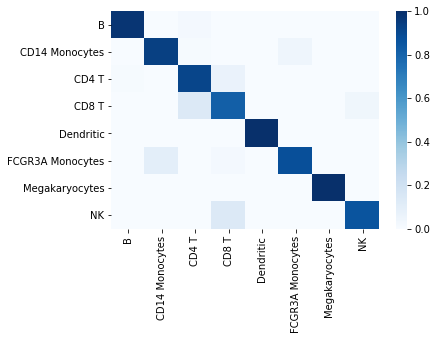

In [10]:
confusion_matrix = pd.DataFrame(data=summary['validation']['confusion_matrix'],
                                columns=summary['model_parameters']['cell_types'],
                                index=summary['model_parameters']['cell_types'])
sns.heatmap(confusion_matrix, cmap='Blues')

## training history

the history object contains loss, accuracy, and f1 scores for the module after each training epoch

loss and f1 scores are also broken down by cell type

In [27]:
summary['history'].keys()

dict_keys(['train_loss', 'validation_loss', 'train_accuracy', 'validation_accuracy', 'cell_type_train_loss', 'cell_type_val_loss', 'cell_type_train_f1', 'cell_type_val_f1'])

plot overall loss and accuracy for training and validation datasets

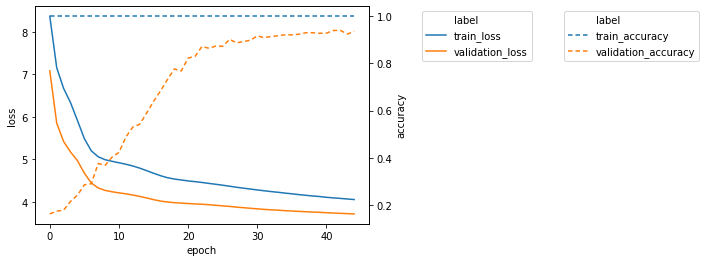

In [28]:
loss, label, epoch = [], [], []
for k in ['train_loss', 'validation_loss']:
    loss += summary['history'][k]
    label += [k] * len(summary['history'][k])
    epoch += list(range(len(summary['history'][k])))
df = pd.DataFrame.from_dict({'label': label, 'loss': loss, 'epoch': epoch})

sns.lineplot(x='epoch', y='loss', data=df, hue='label')
plt.legend(bbox_to_anchor=(1.5, 1))

accuracy, label = [], []
for k in ['train_accuracy', 'validation_accuracy']:
    accuracy += summary['history'][k]
    label += [k] * len(summary['history'][k])
df = pd.DataFrame.from_dict({'label': label, 'accuracy': accuracy, 'epoch': epoch})

ax2 = plt.twinx()
sns.lineplot(x='epoch', y='accuracy', data=df, hue='label', ax=ax2, style='label',
                 dashes=[(3,2), (3,2)])
plt.legend(bbox_to_anchor=(2., 1))

plot validation loss for each cell type during training

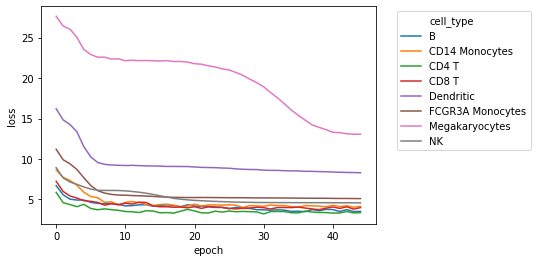

In [29]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_loss']:
    for cell_type, vals in summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'loss': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='loss', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))

plot f1 score for each cell type during training

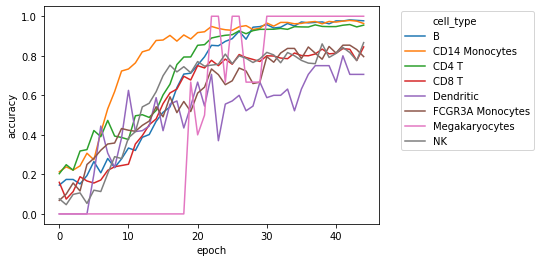

In [30]:
loss, label, epoch = [], [], []
for k in ['cell_type_val_f1']:
    for cell_type, vals in summary['history'][k].items():
        loss += vals
        label += [cell_type] * len(vals)
        epoch += list(range(len(vals)))
    
df = pd.DataFrame.from_dict({
    'cell_type': label,
    'accuracy': loss,
    'epoch': epoch
})

sns.lineplot(x='epoch', y='accuracy', data=df, hue='cell_type')
plt.legend(bbox_to_anchor=(1.05, 1))